In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import math
from scipy import stats
from itertools import combinations

In [2]:
df = pd.read_csv('cells_concat_raw.csv')

In [3]:
## Add delta values
df['Ef_cell_delta'] =  df['Ef_cell_after'] - df['Ef_cell']
df['Ef_nuc_delta'] =  df['Ef_nuc_after'] - df['Ef_nuc']
df['Ef_cyto_delta'] =  df['Ef_cyto_after'] - df['Ef_cyto']


In [4]:
### Data filters

## Removing cells dominated by background and cells reaching saturation
df = df[(df['directA_cell_max'] >= 400) | (df['directA_cell_max'] <= 65000)]
df = df[df['log_directA_cell'] > 2.3]
df = df[df['log_directA_nuc'] > 2.3]
df = df[df['log_directA_cyto'] > 2.3]
df = df[df['log_directA_cell_after'] > 2.3]
df = df[df['log_directA_cyto_after'] > 2.3]
df = df[df['log_directA_nuc_after'] > 2.3]

## Removing cells that have a large change in directA intensity after perturbation (shouldn't happen to healthy cells)
df = df[(df['directA_cell_ratio'] > 0.9) & (df['directA_cell_ratio'] < 1.1)]
## Removing cells that are too circular (likely dead)
df = df[df['circ_cell'] < 0.9]
## Removing cells with negative A_cell_corr - weird stuff going on
df = df[df['A_cell_corr'] > 0]
## Keeping Ef between 0 and 1 - values outside this range are nonsense (very little of these)
df = df[df['Ef_cell'] > 0]
df = df[df['Ef_cell'] < 1]
df = df[df['Ef_cell_after'] > 0]
df = df[df['Ef_cell_after'] < 1]
df = df[df['Ef_cyto'] > 0]
df = df[df['Ef_nuc'] > 0]
df = df[df['Ef_cyto'] < 1]
df = df[df['Ef_nuc'] < 1]
df = df[df['Ef_cyto_after'] > 0]
df = df[df['Ef_nuc_after'] > 0]
df = df[df['Ef_cyto_after'] < 1]
df = df[df['Ef_nuc_after'] < 1]
## removing very small cells and/or debris
df = df[df['area_cell'] > 1000]

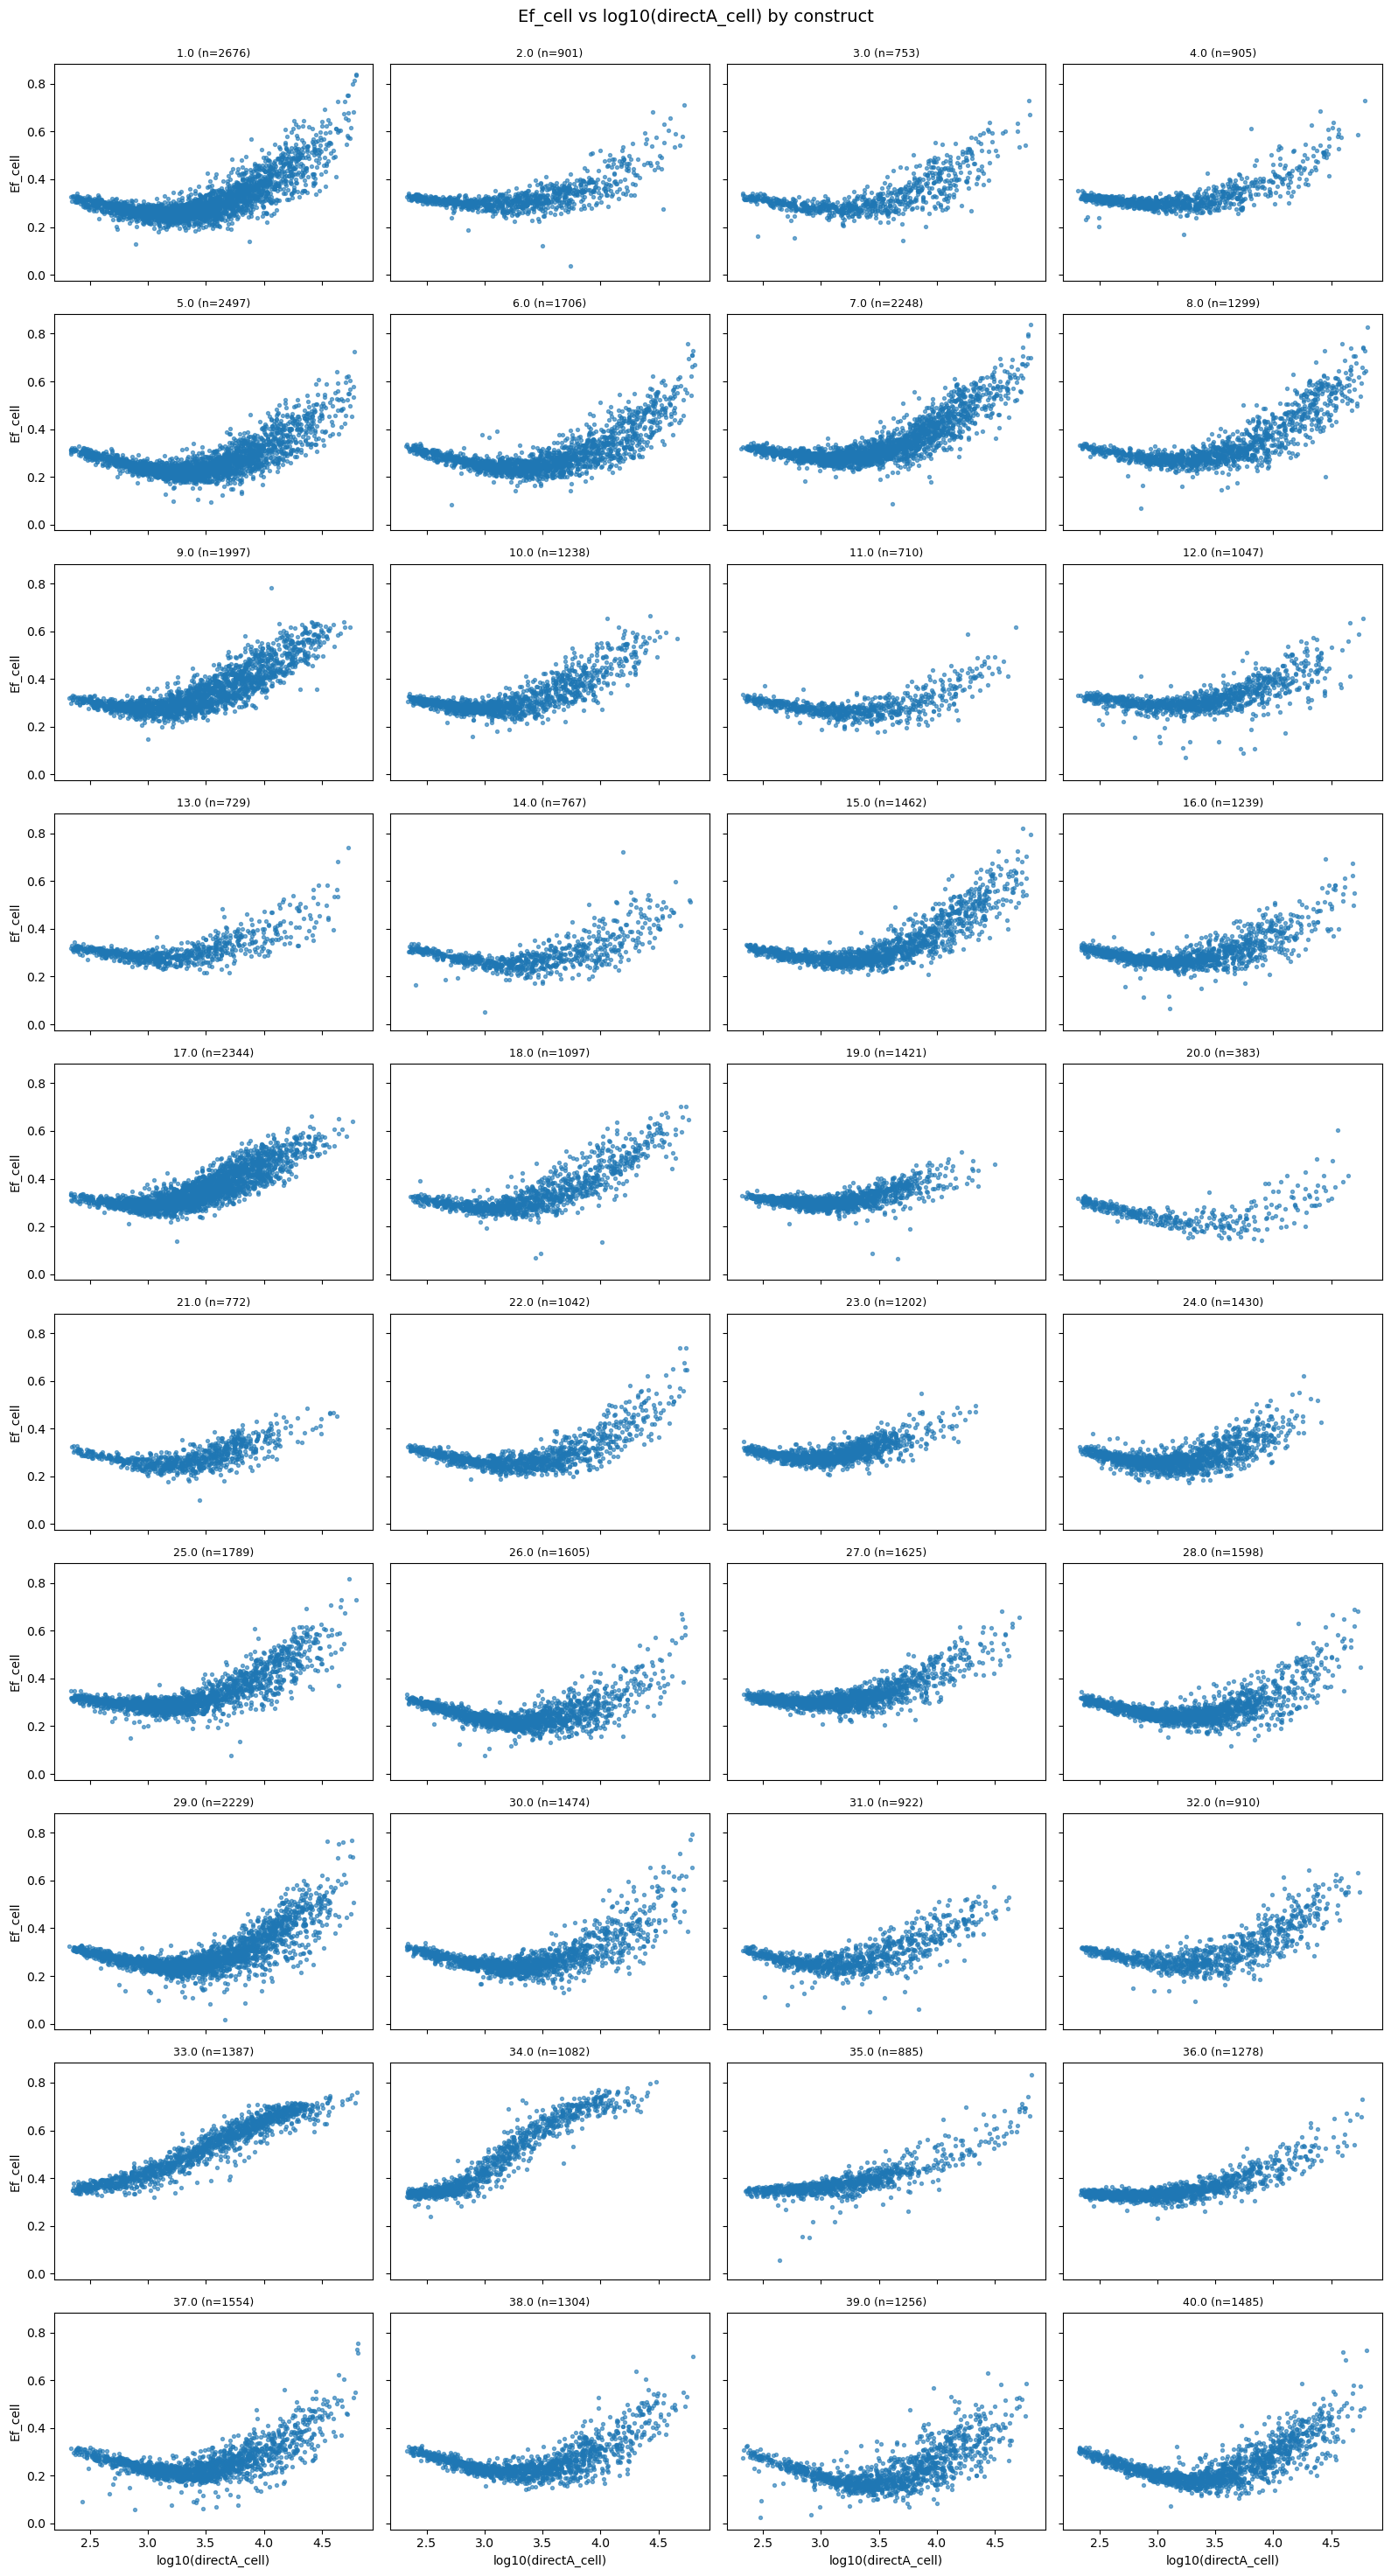

In [5]:
## Plotting to see concentration dependence per construct to see where we need to filter to avoid intermolecular FRET effects

# create a grid of subplots, one per construct, with shared x and y axes
constructs = sorted(df['construct'].unique())
n = len(constructs)
if n == 0:
    raise ValueError("No constructs found in df.")

ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True, sharey=True)
axes = axes.flatten()

for i, construct in enumerate(constructs):
    ax = axes[i]
    sub = df[df['construct'] == construct]
    x = sub['log_directA_cell']
    y = sub['Ef_cell']
    mask = x.notna() & y.notna()
    ax.scatter(x[mask], y[mask], s=8, alpha=0.6)
    ax.set_title(f"{construct} (n={mask.sum()})", fontsize=9)
    # only label left column and bottom row to reduce clutter
    if i % ncols == 0:
        ax.set_ylabel("Ef_cell")
    if i // ncols == nrows - 1:
        ax.set_xlabel("log10(directA_cell)")

# turn off any unused subplots
for j in range(n, nrows * ncols):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Ef_cell vs log10(directA_cell) by construct", fontsize=14)
plt.show()

In [6]:
## Only keeping cells that we believe are not experiencing dominant INTER-molecular FRET effects (only INTRA)
df = df[df['log_directA_cell'] < 3.4]
df = df[df['log_directA_cell'] > 2.7]

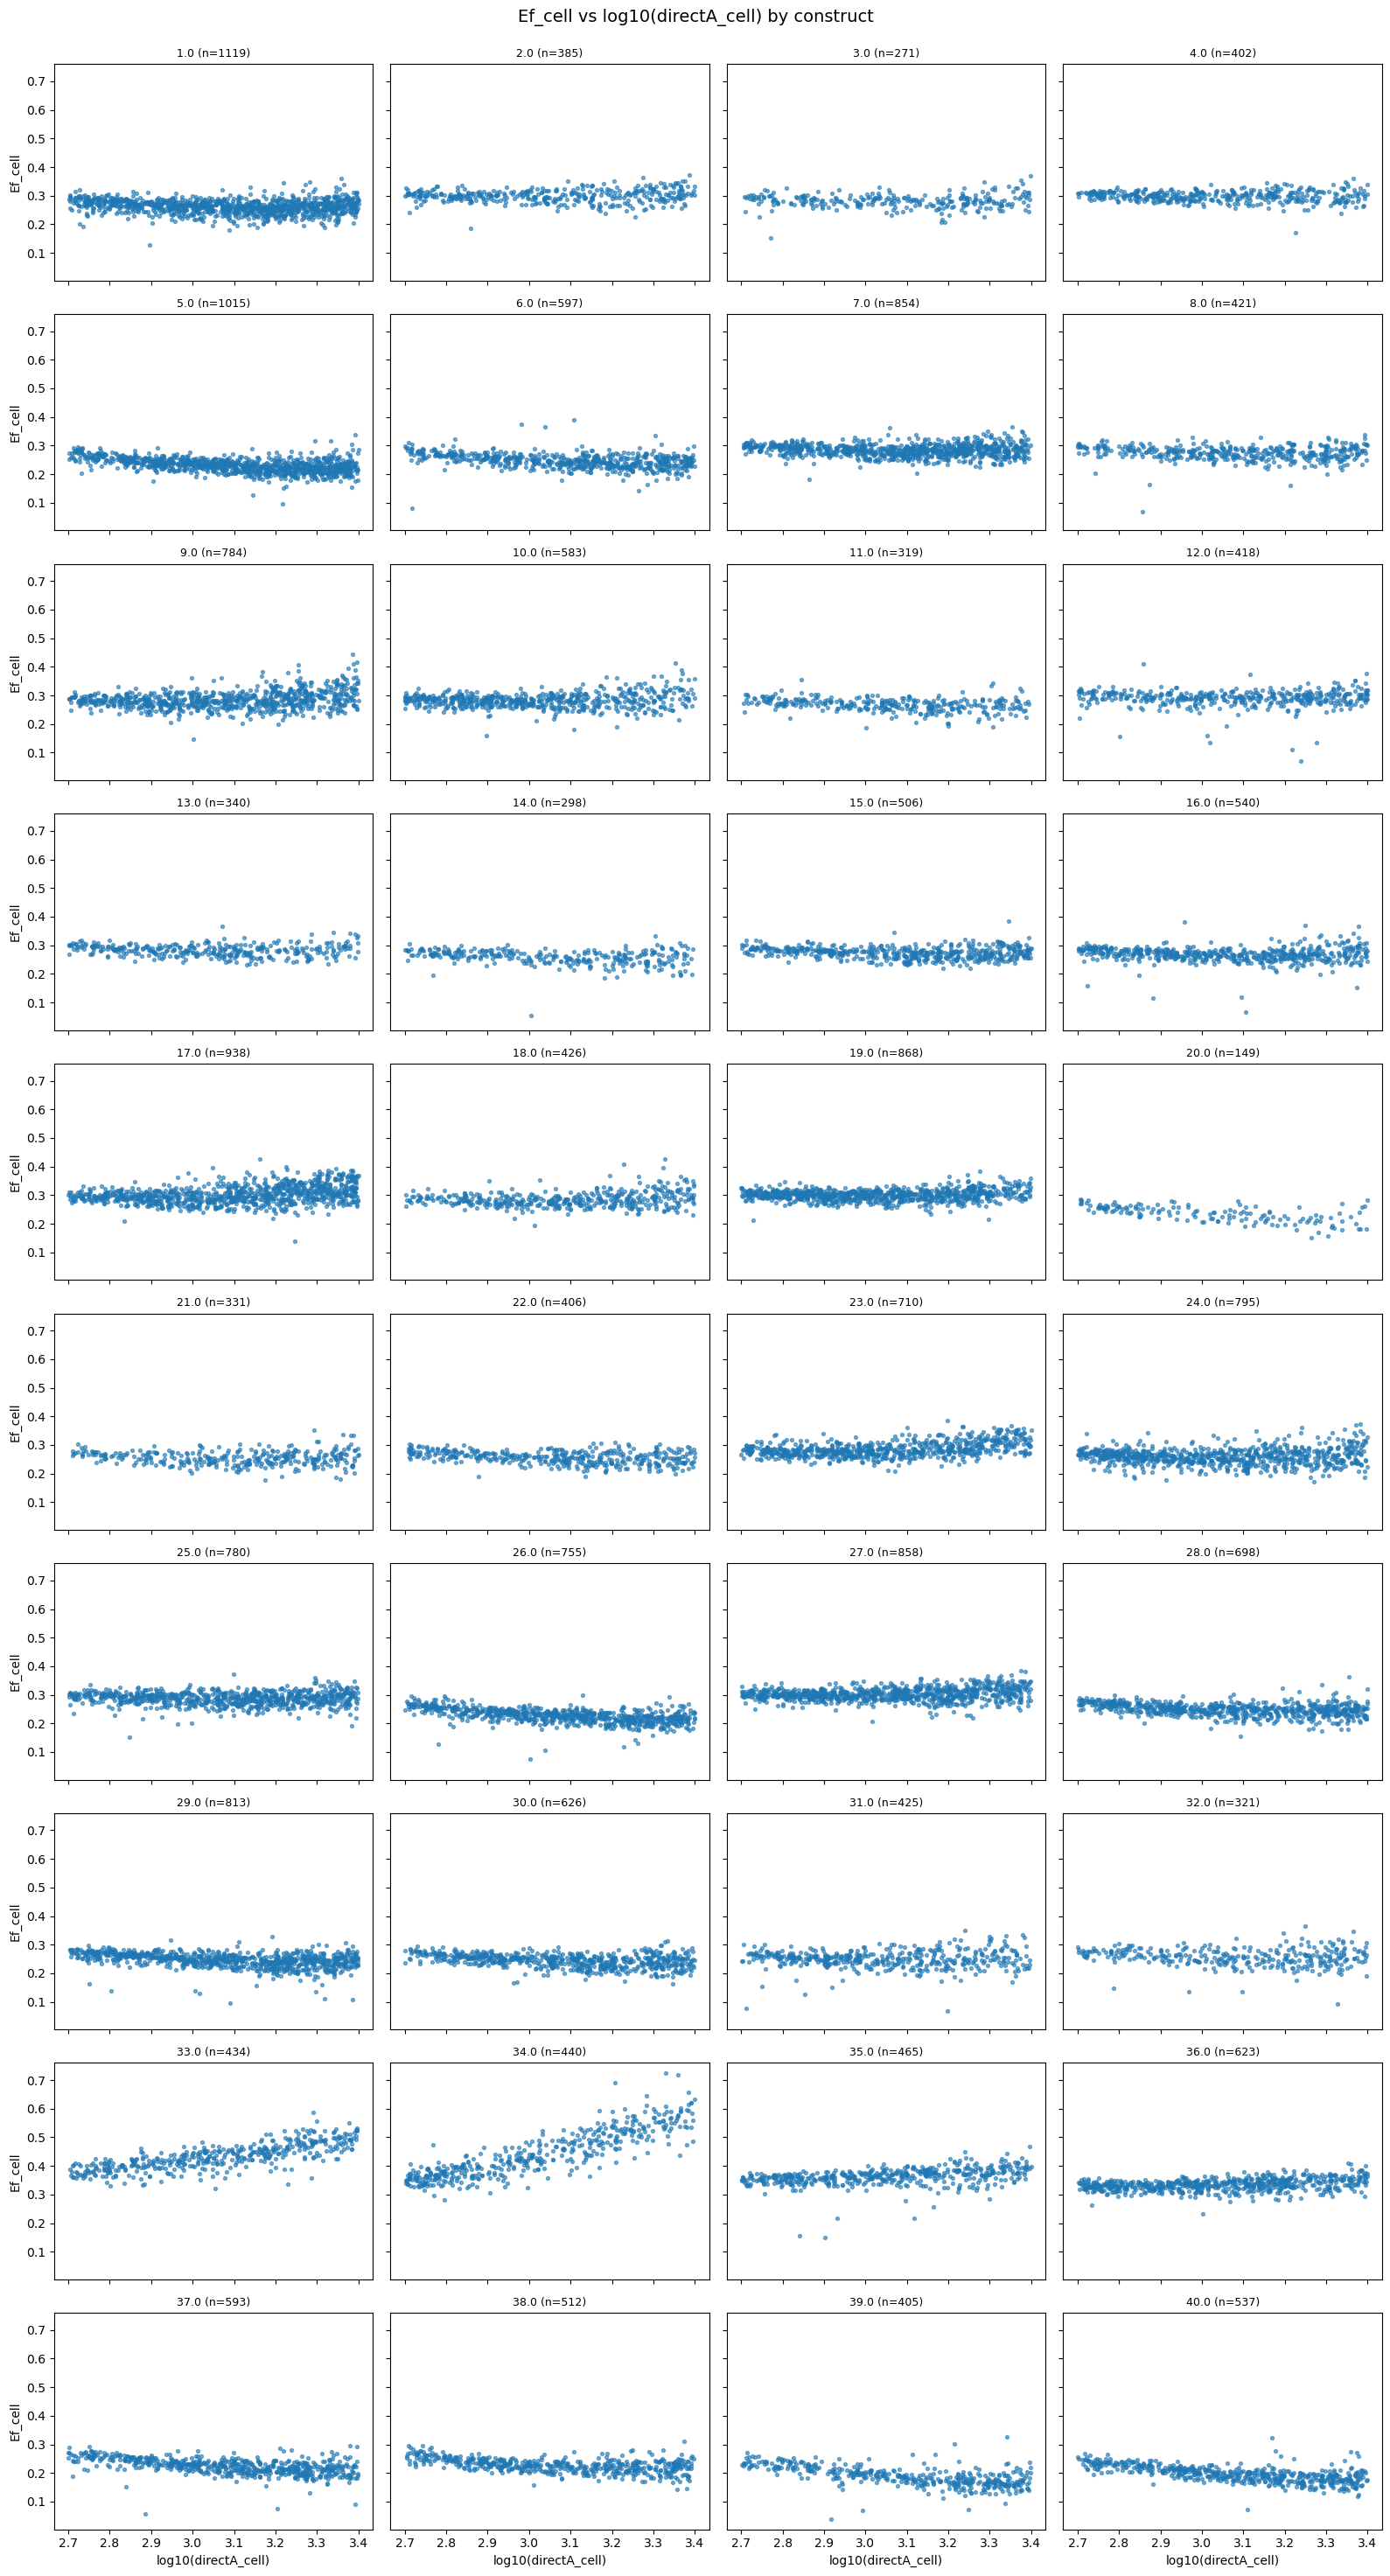

In [7]:
## Plotting to see concentration dependence curves after filters - if linear, we're good.

# create a grid of subplots, one per construct, with shared x and y axes
constructs = sorted(df['construct'].unique())
n = len(constructs)
if n == 0:
    raise ValueError("No constructs found in df.")

ncols = 4
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True, sharey=True)
axes = axes.flatten()

for i, construct in enumerate(constructs):
    ax = axes[i]
    sub = df[df['construct'] == construct]
    x = sub['log_directA_cell']
    y = sub['Ef_cell']
    mask = x.notna() & y.notna()
    ax.scatter(x[mask], y[mask], s=8, alpha=0.6)
    ax.set_title(f"{construct} (n={mask.sum()})", fontsize=9)
    # only label left column and bottom row to reduce clutter
    if i % ncols == 0:
        ax.set_ylabel("Ef_cell")
    if i // ncols == nrows - 1:
        ax.set_xlabel("log10(directA_cell)")

# turn off any unused subplots
for j in range(n, nrows * ncols):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.suptitle("Ef_cell vs log10(directA_cell) by construct", fontsize=14)
plt.show()

In [8]:
# Rename series 2 GEESE to be consistent with main paper numbering
df['construct'] = df['construct'].apply(lambda x: x + 2 if x >= 33 else x)

In [9]:
df.to_csv('cells_concat_filtered.csv', index=False)

In [10]:
## Make aggregated construct dataframe for some paper figures - overall values are the mean of the medians of the filtered raw cell values for each well
## _std is the standard deviation of the well medians

# Group by construct and well, calculate medians
well_medians = df.groupby(['construct', 'well']).agg({
    'Ef_cell': 'median',
    'Ef_cyto': 'median',
    'Ef_nuc': 'median',
    'Ef_cell_delta': 'median',
    'Ef_cyto_delta': 'median',
    'Ef_nuc_delta': 'median',
    'directA_N/C': 'median',
    'directA_N/C_delta': 'median'
}).reset_index()

# Group by construct, calculate mean and std of the well medians, plus counts
construct_stats = well_medians.groupby('construct').agg({
    'Ef_cell': ['mean', 'std'],
    'Ef_cyto': ['mean', 'std'],
    'Ef_nuc': ['mean', 'std'],
    'Ef_cell_delta': ['mean', 'std'],
    'Ef_cyto_delta': ['mean', 'std'],
    'Ef_nuc_delta': ['mean', 'std'],
    'directA_N/C': ['mean', 'std'],
    'directA_N/C_delta': ['mean', 'std'],
    'well': 'count'  # number of wells per construct
}).reset_index()

# Count total cells per construct
cells_per_construct = df.groupby('construct').size().reset_index(name='n_cells')

# Flatten column names
construct_stats.columns = ['construct', 
                           'Ef_cell', 'Ef_cell_std',
                           'Ef_cyto', 'Ef_cyto_std',
                           'Ef_nuc', 'Ef_nuc_std',
                           'Ef_cell_delta', 'Ef_cell_delta_std',
                           'Ef_cyto_delta', 'Ef_cyto_delta_std',
                           'Ef_nuc_delta', 'Ef_nuc_delta_std',
                           'directA_N/C', 'directA_N/C_std',
                           'directA_N/C_delta', 'directA_N/C_delta_std',
                           'n_wells']

# Merge cell counts
construct_stats = construct_stats.merge(cells_per_construct, on='construct')

In [11]:
## Fold in in-vitro data. Crowding is with PEG2K

invitro = pd.read_csv('invitro_conditions.csv')

construct_stats = construct_stats.merge(invitro, on='construct', how='outer')

In [12]:
construct_stats.to_csv('constructs_df.csv')